# Diffusion

In this notebook, we generate the diffusion dataset and look at the POD of it. 

## Imports

We start by importing the stuff we need for this notebook.

In [125]:
import copy
import sys
sys.path.insert(0, '../')

In [126]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [127]:
from pathlib import Path
from timeit import default_timer as timer

import bregman
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
import torch
from tqdm import tqdm

from src.models import DeepAutoEncoder
from src.data.databases.pde_database import Config
from src.data.generate_datasets import generate_diffusion_dataset

In [128]:
# torch.set_default_dtype(torch.float64)

## Settings
We input where to store the generated images and what parameters we'll be using.


In [129]:
results_path = Path("../results/diffusion")

In [130]:
DIFFUSION_LIST_TRAIN = [0.1, 0.5, 1]
DIFFUSION_LIST_TEST = [0.6]

## Generate data
Use the parameters to generate the data.

In [131]:
stacked_train_databases = generate_diffusion_dataset(DIFFUSION_LIST_TRAIN, return_stacked=True)
train_dataset = torch.utils.data.TensorDataset(stacked_train_databases)
test_dataset = generate_diffusion_dataset(DIFFUSION_LIST_TEST)

## Retrieve configurations

During training we don't need these configurations from the datasets, but it's useful for plotting stuff.

In [132]:
config_file = Path(f"../data/diffusion/{DIFFUSION_LIST_TRAIN[0]}/config.json")
config = Config.from_json(config_file.read_text())

domain = torch.linspace(config.xmin, config.xmax, config.Nx)
Nt = config.Nt // 20  # due to subsampling
time = torch.linspace(0, config.T, Nt)

TTx, XX = torch.meshgrid(
    [time, domain],
    indexing="ij",
)

## Plotting a snapshot

In this, we plot the snapshot matrix associated to the first run together with its singular values.

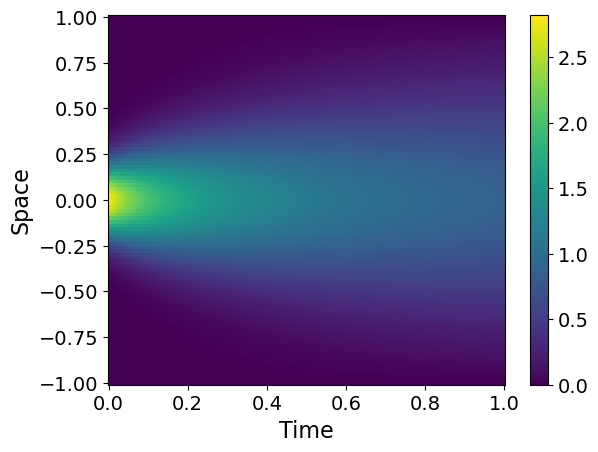

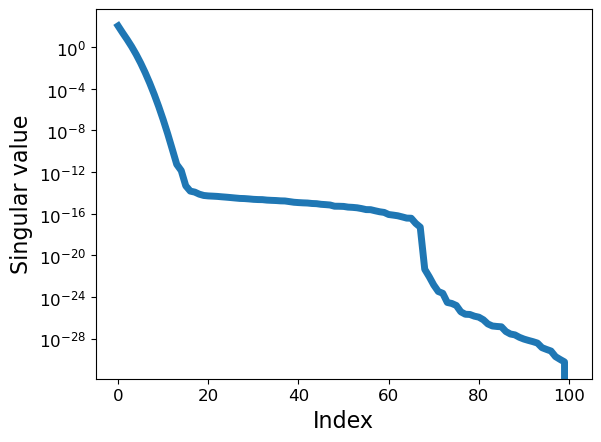

In [133]:
snapshot_matrix = train_dataset[:Nt][0]

plt.figure()
# plt.pcolormesh(TTx, XX, snapshot_matrix.detach(), cmap=mpl.colormaps["plasma_r"])
plt.pcolormesh(TTx, XX, snapshot_matrix.detach())
plt.colorbar()
plt.rc('xtick', labelsize=12)  # fontsize of the tick labels
plt.rc('ytick', labelsize=12)  # fontsize of the tick labels
plt.ylabel("Space", fontsize=16)
plt.xlabel("Time", fontsize=16)
plt.savefig(results_path / "sol.png", bbox_inches='tight')

plt.figure()
plt.semilogy(torch.linalg.svdvals(snapshot_matrix), lw=5)
# plt.semilogy(torch.linalg.svdvals(snapshot_matrix), lw=5, c="magenta")
# plt.xlim((0,25))
plt.rc('xtick', labelsize=14)  # fontsize of the tick labels
plt.rc('ytick', labelsize=14)  # fontsize of the tick labels
plt.ylabel("Singular value", fontsize=16)
plt.xlabel("Index", fontsize=16)
plt.savefig(results_path / "singular.png", bbox_inches='tight')


## Animating the snapshot

Animations are nice, so we make a gif out of the snapshot matrix.

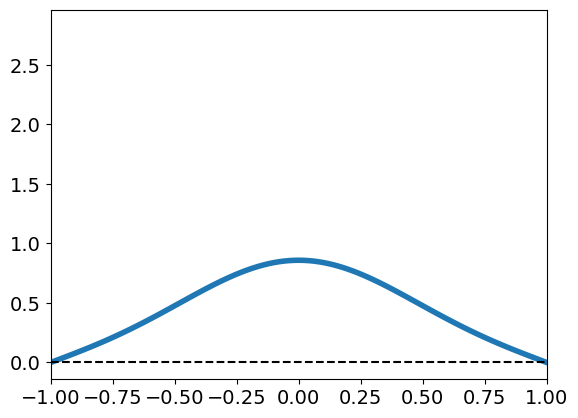

In [160]:
fig = plt.figure()
line, = plt.plot(domain, snapshot_matrix[0,:].detach(), lw=4)
plt.xlim((-1,1))
plt.axhline(0, color="black", linestyle="--")

def animate(k):
    line.set_ydata(snapshot_matrix[5*k,:].detach())
    return line,

# ani = FuncAnimation(fig, animate, interval=40, blit=True, frames=Nt // 5)    
# ani.save(results_path / "diffusion.gif", dpi=300, writer=PillowWriter(fps=25))

## POD

The default ROM is POD, so let's see how well this does on this dataset. 

In [135]:
U, S, Vh = torch.linalg.svd(stacked_train_databases, full_matrices=False)

In [136]:
Sigma = S**2

In [137]:
relative_error = ( torch.sum(Sigma, dim=0) - torch.cumsum(Sigma, dim=0) ) / torch.sum(Sigma, dim=0)

Text(0.5, 0, 'index')

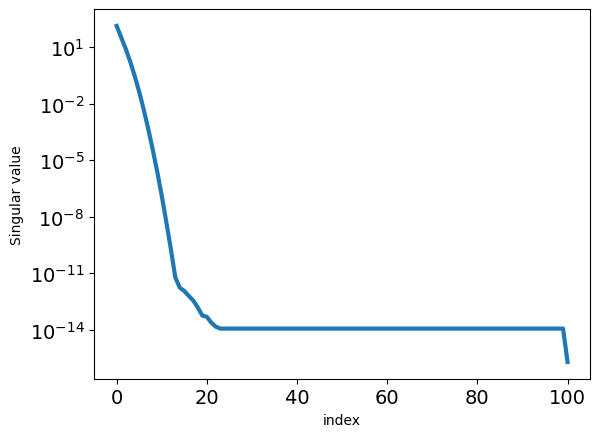

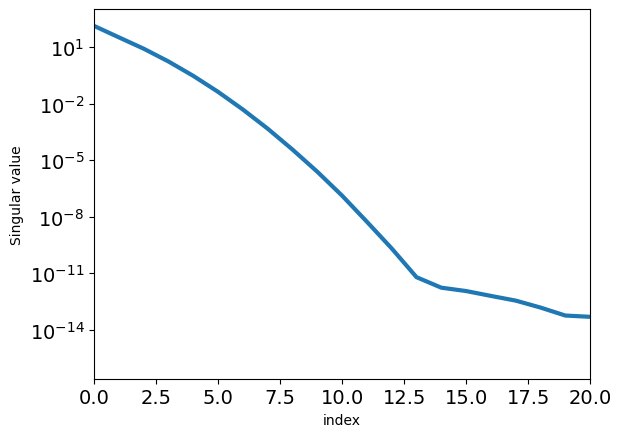

In [138]:
plt.figure()
plt.semilogy(S, lw=3)
plt.ylabel("Singular value")
plt.xlabel("index")

plt.figure()
plt.semilogy(S, lw=3)
plt.xlim((0,20))
plt.ylabel("Singular value")
plt.xlabel("index")


Text(0.5, 0, 'index')

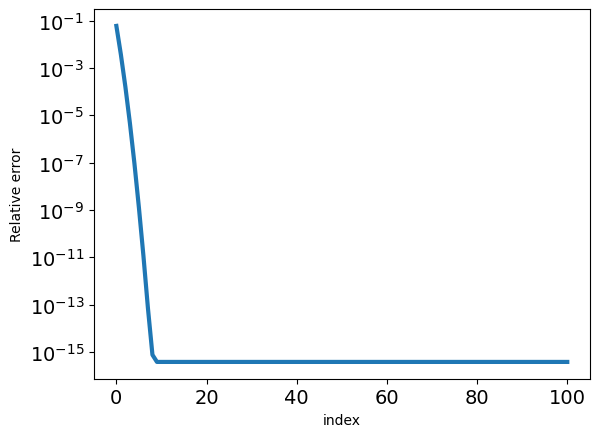

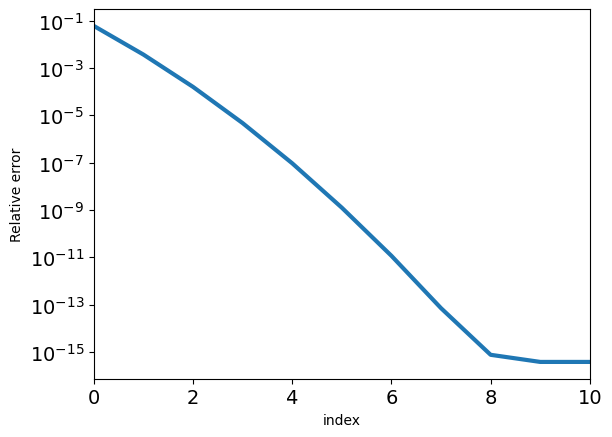

In [139]:
plt.figure()
plt.semilogy(relative_error, lw=3)
plt.ylabel("Relative error")
plt.xlabel("index")


plt.figure()
plt.semilogy(relative_error, lw=3)
plt.xlim((0,10))
plt.ylabel("Relative error")
plt.xlabel("index")


This shows that the singular values decay relatively quickly and the POD requires just a few modes.

In [140]:
ldim = torch.count_nonzero(relative_error >= 1e-6).item() + 1
print("ldim: ", ldim)

ldim:  5


Let's compute the reduced eigenvector matrix.

In [141]:
Vhr = Vh[:ldim,:]

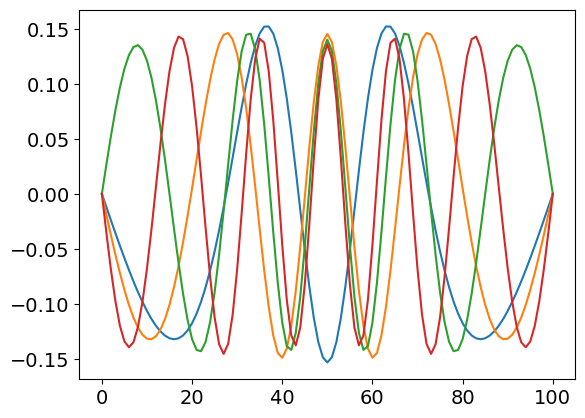

In [142]:
plt.plot(Vh[2,:])
plt.plot(Vh[3,:])
plt.plot(Vh[4,:])
plt.plot(Vh[5,:])


When we compute the error over the entire dataset, we get that the error is indeed as expected.

In [143]:
print(torch.norm(stacked_train_databases - torch.einsum("nm,bn->bm", Vhr.T @ Vhr, stacked_train_databases))**2 / torch.norm(stacked_train_databases)**2)

tensor(9.4883e-08)


We won't compute the errors for the neural networks like this, so let's compute them like we do for them.

In [144]:
loss_functional = torch.nn.MSELoss(reduction="sum")
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=32,
    shuffle=False,
)
test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=32,
    shuffle=False,
)

In [145]:
total_batch_train_loss = 0.0
total_batch_test_loss = 0.0

for (batch,) in tqdm(train_loader):
    loss = loss_functional(batch, torch.zeros_like(batch))
    total_batch_train_loss += loss.item()

for (batch,) in tqdm(train_loader):
    loss = loss_functional(batch, torch.zeros_like(batch))
    total_batch_test_loss += loss.item()


100%|██████████| 24/24 [00:00<00:00, 2132.38it/s]


In [146]:
train_loss_pod = 0.0

for (batch,) in tqdm(train_loader):
    loss = loss_functional(batch, torch.einsum("nm,bn->bm", Vhr.T @ Vhr, batch))
    train_loss_pod += loss.item()

print("Loss (abs): ", train_loss_pod)
print("Loss (rel): ", train_loss_pod / total_batch_train_loss)

100%|██████████| 24/24 [00:00<00:00, 1206.40it/s]

Loss (abs):  0.0018132948863283547
Loss (rel):  9.488277944811689e-08


For the training set this gave the same answer as before, as expected. For the test set we see a different error.

In [147]:
test_loss_pod = 0.0

for (batch,) in tqdm(test_loader):
    loss = loss_functional(batch, torch.einsum("nm,bn->bm", Vhr.T @ Vhr, batch))
    test_loss_pod += loss.item()

print("Loss (abs): ", test_loss_pod)
print("Loss (rel): ", test_loss_pod / total_batch_test_loss)

100%|██████████| 8/8 [00:00<00:00, 2194.82it/s]

Loss (abs):  0.00033679159827253245
Loss (rel):  1.762301497666325e-08


Last for POD, let's plot a solution.

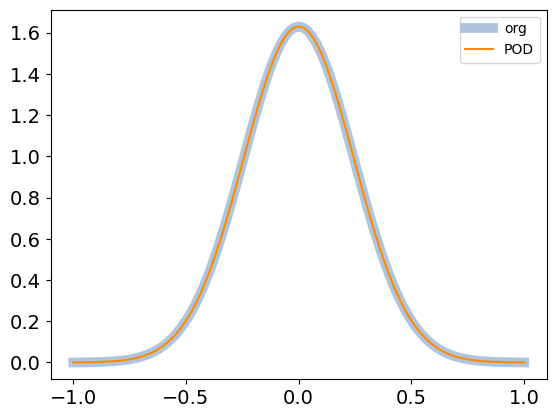

In [109]:
index = 50
plt.figure()
plt.plot(domain, stacked_train_databases[index].detach(), label="org", lw=7, c="lightsteelblue")
plt.plot(domain, (Vhr.T @ Vhr @ stacked_train_databases[index]).detach(), label="POD", c="darkorange")
plt.legend()


## AutoEncoder

We see that POD can capture the solution well with just a few modes. Let's compare that with the neural networks.

In [110]:
from src.utils import init_linear

model = bregman.AutoEncoder(
    encoder_layers=[101, 50, 25, 5],
    decoder_layers=[5, 25, 50, 101],
)
model.apply(init_linear)
bregman.sparsify(model, 0.20)


In [111]:
# optimizer = torch.optim.Adam(model.parameters(), lr=3e-4, weight_decay=0)
from src.utils import nuclear

optimizer = bregman.LinBreg(
    nuclear(model, 1, None),
    lr=3.5,
)
loss_functional = torch.nn.MSELoss()

In [112]:
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=64,
    shuffle=True,
)

Let's compute the models latent dimension in different ways.

In [113]:
U, S, Vh = torch.linalg.svd(model.encoder[-1].weight, full_matrices=False)
Sigma = S ** 2
relative_error = (torch.sum(Sigma, dim=0) - torch.cumsum(Sigma, dim=0)) / torch.sum(Sigma, dim=0)
ldim: int = torch.count_nonzero(relative_error >= 1e-6).item() + 1

print(S)
print(relative_error)
print(ldim)
print("er", model.latent_size("encoder row"))
print("ec", model.latent_size("encoder column"))
print("dr", model.latent_size("decoder row"))
print("f ", model.latent_size("full"))
print("m ", model.latent_size("minimal"))
print("l 1e-6", model.latent_size("latent POD", 1e-6))
print("l 1e-8", model.latent_size("latent POD", 1e-8))
print("es", model.latent_size("encoder spectral"))
print("ds", model.latent_size("decoder spectral"))


tensor([1.0000e+00, 1.1909e-16, 4.0237e-17, 1.2113e-17, 3.3592e-18],
       grad_fn=<LinalgSvdBackward0>)
tensor([0., 0., 0., 0., 0.], grad_fn=<DivBackward0>)
1
er tensor(5)
ec tensor(25)
dr tensor(5)
f  5
m  tensor(5)
l 1e-6 1
l 1e-8 1
es tensor(5)
ds tensor(5)


We now train the model.

In [114]:
train_losses = []
ldims = [torch.linalg.svdvals(model.encoder[-1].weight.data)]
densities = [bregman.network_density(model)]
best_model = None
best_loss = 1e10

In [115]:
epochs=1000
tic = timer()

for epoch in range(1, epochs):
    train_loss = 0.0
    for (batch,) in tqdm(train_loader, desc=f"Training epoch {epoch}"):
        optimizer.zero_grad()

        loss = loss_functional(batch, model(batch))

        loss.backward()
        optimizer.step()

        train_loss += loss.item()
    train_losses.append(train_loss)
    if train_loss < best_loss:
        best_model = copy.deepcopy(model)
    densities.append(bregman.network_density(model))
    ldims.append(torch.linalg.svdvals(model.encoder[-1].weight.data))

toc = timer()
print(f"{epochs} epochs took {toc-tic:.04f} seconds, meaning approx {(toc-tic)/epochs:.04f} sec/epoch or {epochs/(toc-tic):.04f} epochs/sec.")


Training epoch 999: 100%|██████████| 12/12 [00:00<00:00, 353.58it/s]


1000 epochs took 40.0511 seconds, meaning approx 0.0401 sec/epoch or 24.9681 epochs/sec.


Text(0, 0.5, 'Singular vectors')

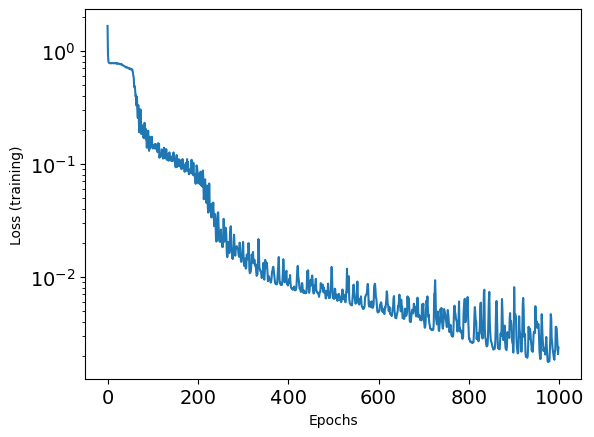

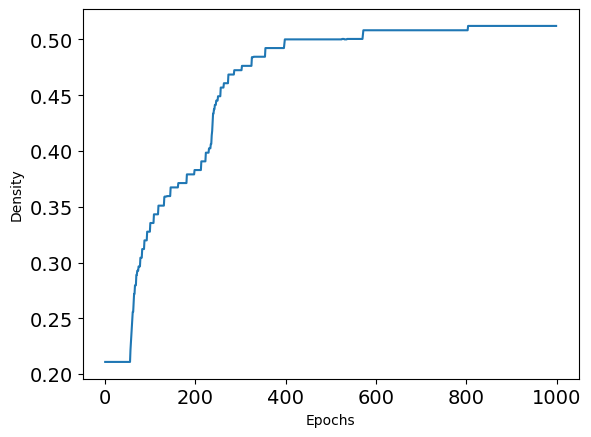

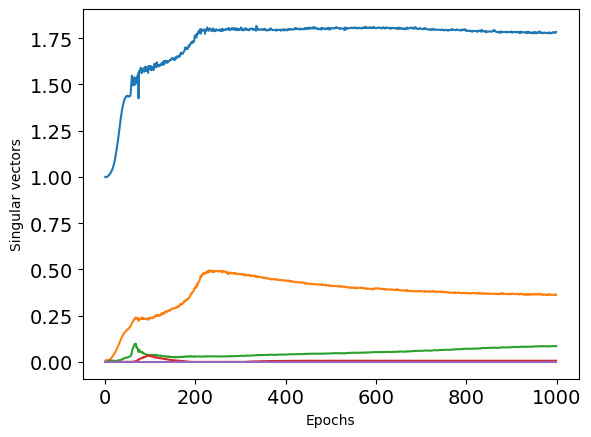

In [116]:
plt.figure()
plt.semilogy(train_losses)
plt.xlabel("Epochs")
plt.ylabel("Loss (training)")

plt.figure()
plt.plot(densities)
plt.xlabel("Epochs")
plt.ylabel("Density")

plt.figure()
plt.plot(ldims)
plt.xlabel("Epochs")
plt.ylabel("Singular vectors")


The models latent dimension will have changed.

In [117]:
U, S, Vh = torch.linalg.svd(best_model.encoder[-1].weight, full_matrices=False)
Sigma = S ** 2
relative_error = (torch.sum(Sigma, dim=0) - torch.cumsum(Sigma, dim=0)) / torch.sum(Sigma, dim=0)
ldim: int = torch.count_nonzero(relative_error >= 1e-6).item() + 1

print(S)
print(relative_error)
print(ldim)
print("er", best_model.latent_size("encoder row"))
print("ec", best_model.latent_size("encoder column"))
print("dr", best_model.latent_size("decoder row"))
print("f ", best_model.latent_size("full"))
print("m ", best_model.latent_size("minimal"))
print("l 1e-6", best_model.latent_size("latent POD", 1e-6))
print("l 1e-8", best_model.latent_size("latent POD", 1e-8))
print("es", best_model.latent_size("encoder spectral"))
print("ds", best_model.latent_size("decoder spectral"))


tensor([1.7828e+00, 3.6237e-01, 8.5376e-02, 6.2519e-03, 1.8959e-16],
       grad_fn=<LinalgSvdBackward0>)
tensor([4.1796e-02, 2.2092e-03, 1.1783e-05, 0.0000e+00, 0.0000e+00],
       grad_fn=<DivBackward0>)
4
er tensor(5)
ec tensor(25)
dr tensor(9)
f  5
m  tensor(5)
l 1e-6 4
l 1e-8 4
es tensor(5)
ds tensor(5)


## Pruning

In [118]:
latent_model = bregman.latent_pod(model, 1e-8)

In [119]:
U, S, Vh = torch.linalg.svd(best_model.encoder[-1].weight, full_matrices=False)
Sigma = S ** 2
relative_error = (torch.sum(Sigma, dim=0) - torch.cumsum(Sigma, dim=0)) / torch.sum(Sigma, dim=0)
ldim: int = torch.count_nonzero(relative_error >= 1e-6).item() + 1

print(S)
print(relative_error)
print(ldim)
print("er", latent_model.latent_size("encoder row"))
print("ec", latent_model.latent_size("encoder column"))
print("dr", latent_model.latent_size("decoder row"))
print("f ", latent_model.latent_size("full"))
print("m ", latent_model.latent_size("minimal"))
print("l 1e-6", latent_model.latent_size("latent POD", 1e-6))
print("l 1e-8", latent_model.latent_size("latent POD", 1e-8))
print("es", latent_model.latent_size("encoder spectral"))
print("ds", latent_model.latent_size("decoder spectral"))
print(latent_model.encoder_layers)
print(latent_model.decoder_layers)

tensor([1.7828e+00, 3.6237e-01, 8.5376e-02, 6.2519e-03, 1.8959e-16],
       grad_fn=<LinalgSvdBackward0>)
tensor([4.1796e-02, 2.2092e-03, 1.1783e-05, 0.0000e+00, 0.0000e+00],
       grad_fn=<DivBackward0>)
4
er tensor(4)
ec tensor(25)
dr tensor(9)
f  4
m  tensor(4)
l 1e-6 4
l 1e-8 4
es tensor(4)
ds tensor(4)
[101, 50, 25, 4]
[4, 25, 50, 101]


In [120]:
pruned_model = bregman.simplify(latent_model)

In [121]:
U, S, Vh = torch.linalg.svd(pruned_model.encoder[-1].weight, full_matrices=False)
Sigma = S ** 2
relative_error = (torch.sum(Sigma, dim=0) - torch.cumsum(Sigma, dim=0)) / torch.sum(Sigma, dim=0)
ldim: int = torch.count_nonzero(relative_error >= 1e-6).item() + 1

print(S)
print(relative_error)
print(ldim)
print("er", pruned_model.latent_size("encoder row"))
print("ec", pruned_model.latent_size("encoder column"))
print("dr", pruned_model.latent_size("decoder row"))
print("f ", pruned_model.latent_size("full"))
print("m ", pruned_model.latent_size("minimal"))
print("l 1e-6", pruned_model.latent_size("latent POD", 1e-6))
print("l 1e-8", pruned_model.latent_size("latent POD", 1e-8))
print("es", pruned_model.latent_size("encoder spectral"))
print("ds", pruned_model.latent_size("decoder spectral"))
print(pruned_model.encoder_layers)
print(pruned_model.decoder_layers)

tensor([1.6495, 0.1727, 0.0094, 0.0018], grad_fn=<LinalgSvdBackward0>)
tensor([1.0870e-02, 3.3024e-05, 1.2058e-06, 0.0000e+00],
       grad_fn=<DivBackward0>)
4
er tensor(4)
ec tensor(5)
dr tensor(9)
f  4
m  tensor(4)
l 1e-6 4
l 1e-8 4
es tensor(4)
ds tensor(4)
[101, 10, 5, 4]
[4, 9, 10, 101]


# POD vs Optimizer

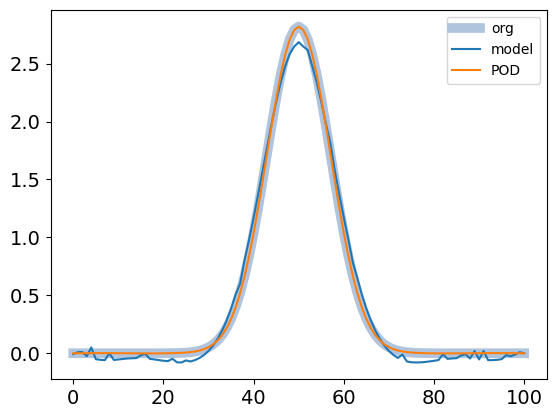

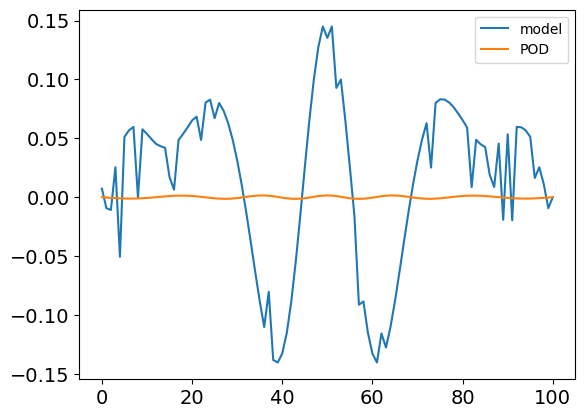

In [122]:
index = 0

plt.figure()
plt.plot(stacked_train_databases[index].detach(), label="org", lw=7, c="lightsteelblue")
plt.plot(model(stacked_train_databases[index]).detach(), label="model")
plt.plot((Vhr.T @ Vhr @ stacked_train_databases[index]).detach(), label="POD")
plt.legend()

plt.figure()
plt.plot((stacked_train_databases[index] - model(stacked_train_databases[index])).detach(), label="model")
plt.plot((stacked_train_databases[index] - Vhr.T @ Vhr @ stacked_train_databases[index]).detach(), label="POD")
plt.legend()

In [123]:
test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=32,
    shuffle=False,
)

In [124]:
test_loss_model = 0.0
test_loss_pod = 0.0

for (batch,) in tqdm(test_loader):
    loss = loss_functional(batch, torch.einsum("nm,bn->bm", Vhr.T @ Vhr, batch))
    test_loss_pod += loss.item()

    loss = loss_functional(batch, model(batch))
    test_loss_model += loss.item()

print("model: ", test_loss_model)
print("POD: ", test_loss_pod)


100%|██████████| 8/8 [00:00<00:00, 1241.65it/s]

model:  0.0017795841451456206
POD:  1.0438528310266688e-07
